# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
 -1.0
  1.0
  1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
  ⋮
  1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0

### We create a function to visualize the data

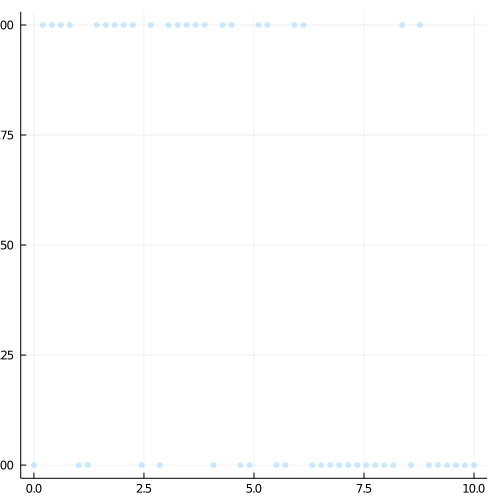

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

┌ Info: Running full model
└ @ Main.##384 string:1
  0.536001 seconds (1.14 M allocations: 66.653 MiB, 99.31% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

┌ Info: Sampling from model
└ @ Main.##384 string:1
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:04
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:34
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:43
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:17
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:01
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:51
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:38
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:25
Sampling with Gi

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.16861529328972885, 0.15499947539441028, 0.2181599905917378, 0.3500992361286371, 0.5461246754498499, 0.7325733313120798, 0.8321521801596423, 0.8475151158061593, 0.7440085350590444, 0.5821896731901693  …  -2.1383567875729694, -1.8316475143881492, -1.5271515280586139, -1.3190912504076606, -1.1598072403397364, -1.0255517365149287, -0.9790497815057568, -0.9164516474882551, -0.900669268432264, -0.8845544943193354]]
 [[0.6911548413537298, 0.7031728828218186, 0.6800097793197665, 0.6702379107550093, 0.6503450030989977, 0.6279391737829262, 0.6557646631698546, 0.7205024963616233, 0.8079044909298092, 0.8556963199853314  …  -0.4015483131667118, -0.3995973456066042, -0.3848569439999425, -0.3820720595956238, -0.31953658931662876, -0.24428073687299767, -0.10146714699958503, 0.03388164714539332, 0.1462027851492238, 0.24788698270188791]]
 [[0.2462246378398527, 0.13035544922847236, -0.008457707320826013, -0.11659783975099225, -0.18803286856196122, -0.263

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

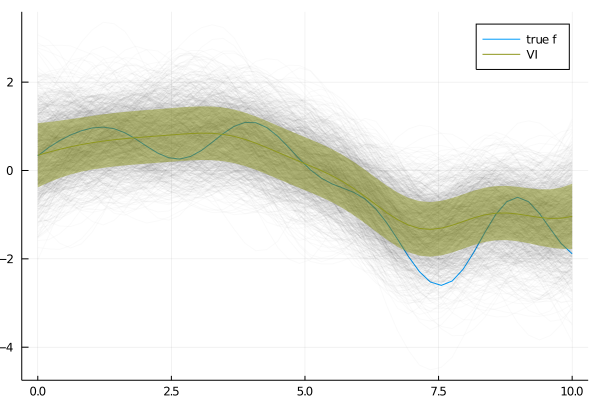

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

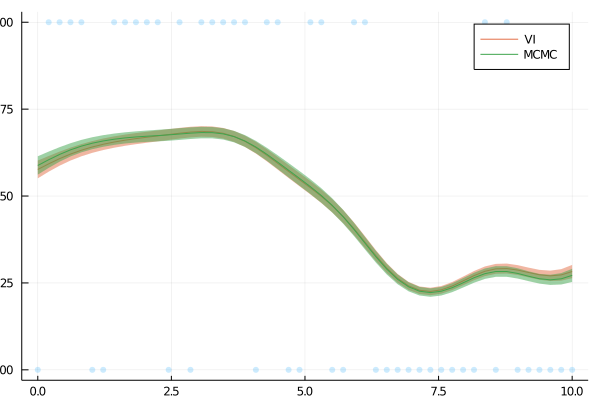

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*